In [2]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

# utility function
# @tf.function


def u(c):
    return c**(1-gamma)/(1-gamma)


def u_deriv(c):
    return c**(-gamma)


# @tf.function
def u_deriv_inv(c):
    return c**(-1/gamma)


# Define initial condition
# def fun_u_0(x):
#     return -tf.sin(pi * x)

# Define boundary condition
def fun_v_b_a(a, z):
    return u_deriv(z+r*a)


def fun_v_b_z(a, z):
    n = z.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)


# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Parameter
gamma = 0.5
r = 0.03
rho = 0.05
Var = 0.07
Corr = 0.9
the = -np.log(Corr)
sig2 = 2*the*Var
cap_u = 1e-3
cap_c = 1e-3
eps2=1e-5

# Set constants
gamma = tf.constant(gamma, dtype=DTYPE)
r = tf.constant(r, dtype=DTYPE)
rho = tf.constant(rho, dtype=DTYPE)
# zmean = tf.constant(zmean, dtype=DTYPE)
the = tf.constant(the, dtype=DTYPE)
sig2 = tf.constant(sig2, dtype=DTYPE)

cap_u = tf.Variable(cap_u, dtype=DTYPE)
cap_c = tf.Variable(cap_c, dtype=DTYPE)



# Set number of data points
N_b = 200
N_r = 10000

# Set boundary
zmean = np.exp(Var/2)

amin = -0.02
amax = 4
zmin = zmean*0.8
zmax = zmean*1.2




In [3]:
# def u(c):
#     return c**(1-gamma)/(1-gamma)



# def u_deriv_inv(c):
#     return c**(-1/gamma)



# def fun_v_b_a(a, z):
#     return u_deriv(z+r*a)


# def fun_v_b_z(a, z):
#     n = z.shape[0]
#     return tf.zeros((n, 1), dtype=DTYPE)


# Lower bounds
lb = tf.constant([amin, zmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([amax, zmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)


a_b_z = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
z_b_z = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)
X_b_z = tf.concat([a_b_z, z_b_z], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b_z = fun_v_b_z(a_b_z, z_b_z)


# Draw uniformly sampled collocation points
a_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
z_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([a_r, z_r], axis=1)

# Collect boundary and inital data in lists
# X_data = [X_b_a, X_b_z]
# u_data = [u_b_a, u_b_z]

X_eq = X_b_z
u_eq = u_b_z


a_b_a = lb[0] * tf.ones((N_b, 1), dtype=DTYPE)
z_b_a = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype=DTYPE)
X_b_a = tf.concat([a_b_a, z_b_a], axis=1)
u_b_a = fun_v_b_a(a_b_a, z_b_a)

X_ineq = X_b_a
u_ineq = u_b_a

a_b_a2 = ub[0] * tf.ones((N_b, 1), dtype=DTYPE)
z_b_a2 = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype=DTYPE)
X_b_a2 = tf.concat([a_b_a2, z_b_a2], axis=1)
u_b_a2 = fun_v_b_a(a_b_a2, z_b_a2)

X_ineq2 = X_b_a2
u_ineq2 = u_b_a2


# Draw uniformly sampled collocation points
a_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
z_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([a_r, z_r], axis=1)



In [4]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [5]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        
        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
            u_x = tape.gradient(u, self.x)
            
            u_t = tape.gradient(u, self.t)
            
        u_tt = tape.gradient(u_t, self.t)
 
        u_xx = tape.gradient(u_x, self.x)

        del tape
        
        temp = tf.maximum(u_tt,
                                              tf.zeros_like(u_tt), name='opt_punish_state')
        phi_temp = tf.reduce_mean(tf.square(temp))
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx) + 3*phi_temp
    
    def loss_fn(self, X_eq, u_eq, X_ineq, u_ineq, X_ineq2, u_ineq2):
        
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        with tf.GradientTape(persistent=True) as tape:
            # Split t and x to compute partial derivatives
            a, z = X_eq[:, 0:1], X_eq[:, 1:2]
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape.watch(a)
            tape.watch(z)

        #     # Determine residual
            v_eq = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

        #     # Compute gradient u_x within the GradientTape
        #     # since we need second derivatives
            v_eq_a = tape.gradient(v_eq, a)
        # v_eq_aa = tape.gradient(v_eq_a, a)

        v_eq_z = tape.gradient(v_eq, z)
        # opt_punish_statea = tf.maximum(v_eq_aa,
        #                                tf.zeros_like(v_eq_aa), name='opt_punish_state')
        del tape
        
        phi_1 = tf.reduce_mean(tf.square(u_eq - v_eq_z)) 
            # tf.reduce_mean(tf.square(opt_punish_statea))

        with tf.GradientTape(persistent=True) as tape:
            # Split t and x to compute partial derivatives
            a, z = X_ineq[:, 0:1], X_ineq[:, 1:2]
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape.watch(a)
            tape.watch(z)

        #     # Determine residual
            v_ineq = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

        #     # Compute gradient u_x within the GradientTape
        #     # since we need second derivatives
        v_ineq_a = tape.gradient(v_ineq, a)
        # v_ineq_aa = tape.gradient(v_ineq_a, a)

        del tape
        
        state_orig = v_ineq_a - u_ineq
        
        opt_punish_state =  tf.maximum(-1 * state_orig,
                                                tf.zeros_like(state_orig), name='opt_punish_state')
        # opt_punish_statea = tf.maximum(v_ineq_aa,
        #                                tf.zeros_like(v_ineq_aa), name='opt_punish_state')
        phi_2 = tf.reduce_mean(tf.square(opt_punish_state)) 
            # tf.reduce_mean(tf.square(opt_punish_statea))
        
        with tf.GradientTape(persistent=True) as tape:
            # Split t and x to compute partial derivatives
            a, z = X_ineq2[:, 0:1], X_ineq2[:, 1:2]
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape.watch(a)
            tape.watch(z)

        #     # Determine residual
            v_ineq2 = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

        #     # Compute gradient u_x within the GradientTape
        #     # since we need second derivatives
        v_ineq2_a = tape.gradient(v_ineq2, a)
        # v_ineq2_aa = tape.gradient(v_ineq2_a, a)

        del tape

        state_orig2 = v_ineq2_a - u_ineq2

        opt_punish_state2 = tf.maximum( state_orig2,
                                              tf.zeros_like(state_orig2), name='opt_punish_state')
        # opt_punish_state2a = tf.maximum(v_ineq2_aa,
        #                                        tf.zeros_like(v_ineq2_aa), name='opt_punish_state')
        phi_3 = tf.reduce_mean(tf.square(opt_punish_state2)) 
            # tf.reduce_mean(tf.square(opt_punish_state2a))
        
        loss += (5)*phi_1
        loss += (5) * phi_2
        loss += 10 * phi_3

        return loss
    
    def get_grad(self,  X_eq, u_eq, X_ineq, u_ineq, X_ineq2, u_ineq2):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X_eq, u_eq, X_ineq, u_ineq, X_ineq2, u_ineq2)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g

    def u(self, c):
        return c**(1-gamma)/(1-gamma)


    def u_deriv_inv(self, c):
        return c**(-1/gamma)

    def fun_r(self, a, z, v, v_a, v_z, v_zz):
        length = a.shape[0]

        # v_a = tf.where(v_a <= cap, cap*tf.ones((length, 1),
        #              dtype=DTYPE), v_a)

        c = tf.where(v_a <= 0, tf.zeros((length, 1),
                                        dtype=DTYPE), self.u_deriv_inv(v_a))
        u_c = self.u(c)
        # tf.print(tf.math.reduce_max(u_deriv_inv(v_a)), tf.math.reduce_max(
        #     v_a), tf.math.reduce_max(v_z), tf.math.reduce_max(v_zz))
        return -rho*v+u_c+v_a*(z+r*a-c)+(-the*tf.math.log(z)+sig2/2)*v_z + sig2*z**2/2*v_zz
        
    def solve_with_TFoptimizer(self, optimizer, X_eq, u_eq, X_ineq, u_ineq, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X_eq, u_eq, X_ineq, u_ineq)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X_eq, u_eq, X_ineq, u_ineq, X_ineq2, u_ineq2, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(
                X_eq, u_eq, X_ineq, u_ineq, X_ineq2, u_ineq2)
            
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, xr=None):
        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_solution_va(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(), X.flatten()]).T

        with tf.GradientTape(persistent=True) as tape:
            # Split t and x to compute partial derivatives
            a, z = tf.cast(Xgrid, DTYPE)[:, 0:1], tf.cast(Xgrid, DTYPE)[:, 1:2]
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape.watch(a)
            tape.watch(z)

        #     # Determine residual
            v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

        #     # Compute gradient u_x within the GradientTape
        #     # since we need second derivatives
        v_a = tape.gradient(v, a)
        del tape
        
        # # Determine predictions of u(t, x)
        v_aplot = v_a.numpy().reshape(N+1, N+1)
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, v_aplot, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$\partial v \partial a(a,z)$')
        # ax.view_init(35, 35)
        return ax
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax
    

In [6]:
# Initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None, 2))

# Initilize PINN solver
solver = PINNSolver(model, X_r)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# Start timer
t0 = time.time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [1000, 3000], [1e-2, 1e-3, 5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_eq, u_eq, X_ineq, u_ineq, N=4001)

elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_eq, u_eq, X_ineq, u_ineq, X_ineq2, u_ineq2,
                                     method='L-BFGS-B',
                                     options={'maxiter': 500000,
                                              'maxfun': 500000,
                                              'maxcor': 500,
                                              'gtol': 1.0*np.finfo(float).eps,
                                              'maxls': 500,
                                              'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time.time()-t0))


It 00000: loss = 1.67829628e+01
It 00010: loss = 6.17456341e+00
It 00020: loss = 4.33484364e+00
It 00030: loss = 3.93058515e+00
It 00040: loss = 3.17843390e+00
It 00050: loss = 2.74228239e+00
It 00060: loss = 2.61127162e+00
It 00070: loss = 2.49229264e+00
It 00080: loss = 2.37243438e+00
It 00090: loss = 2.09802818e+00
It 00100: loss = 1.95269287e+00
It 00110: loss = 1.79177582e+00
It 00120: loss = 1.72119594e+00
It 00130: loss = 1.58622360e+00
It 00140: loss = 1.53345692e+00
It 00150: loss = 1.42236352e+00
It 00160: loss = 1.36027980e+00
It 00170: loss = 1.11243832e+00
It 00180: loss = 1.03895497e+00
It 00190: loss = 8.86170208e-01
It 00200: loss = 7.14882374e-01
It 00210: loss = 4.58301723e-01
It 00220: loss = 3.08644235e-01
It 00230: loss = 1.75438255e-01
It 00240: loss = 6.93525672e-02
It 00250: loss = 3.75316814e-02
It 00260: loss = 1.95111781e-02
It 00270: loss = 9.81723890e-03
It 00280: loss = 7.88517389e-03
It 00290: loss = 5.94979804e-03
It 00300: loss = 4.64681117e-03
It 00310

In [25]:
solver.solve_with_ScipyOptimizer(X_eq, u_eq, X_ineq, u_ineq, X_ineq2, u_ineq2,
                                 method='L-BFGS-B',
                                 options={'maxiter': 50000,
                                          'maxfun': 50000,
                                          'maxcor': 50,
                                          'gtol': 1.0*np.finfo(float).eps,
                                          'maxls': 50,
                                          'ftol': 1.0*np.finfo(float).eps})


It 00480: loss = 2.87111220e-03
It 00490: loss = 2.86204414e-03
It 00500: loss = 2.83285975e-03
It 00510: loss = 2.77683814e-03
It 00520: loss = 2.57405639e-03
It 00530: loss = 2.50464585e-03
It 00540: loss = 2.37437850e-03
It 00550: loss = 2.35906336e-03
It 00560: loss = 2.14841613e-03
It 00570: loss = 2.13358412e-03
It 00580: loss = 1.93067640e-03
It 00590: loss = 1.91370305e-03
It 00600: loss = 1.82711368e-03
It 00610: loss = 1.73699844e-03
It 00620: loss = 1.68854278e-03
It 00630: loss = 1.66181196e-03
It 00640: loss = 1.65359769e-03
It 00650: loss = 1.51812937e-03
It 00660: loss = 1.51303411e-03
It 00670: loss = 1.48264493e-03
It 00680: loss = 1.40905508e-03
It 00690: loss = 1.39142817e-03
It 00700: loss = 1.31658779e-03
It 00710: loss = 1.25245436e-03
It 00720: loss = 1.24073424e-03
It 00730: loss = 1.23638532e-03


      fun: 0.0012260578805580735
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00651488, -0.00183507,  0.00197456, ...,  0.0001144 ,
        0.00043674,  0.00043423])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 364
      nit: 261
     njev: 364
   status: 0
  success: True
        x: array([ 0.62507736, -1.21968518, -0.5163083 , ..., -2.51835599,
        2.04479346,  3.65051752])

<AxesSubplot:xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

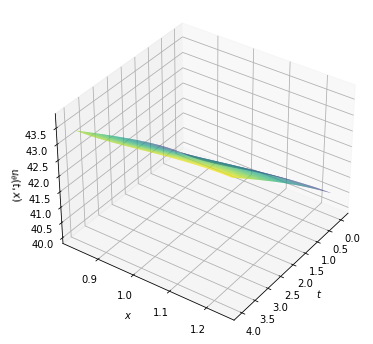

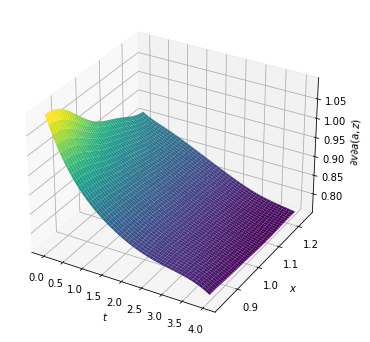

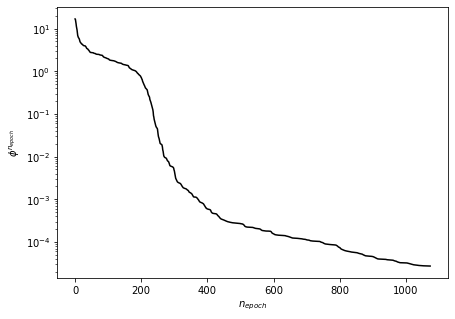

In [7]:
solver.plot_solution()
solver.plot_solution_va()
solver.plot_loss_history()


In [47]:
## Save Model:

import os

model.summary()
checkpoint_path = "success/TryNBC_ub_weight_1_5_5_10-{epoch}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model.save_weights(checkpoint_path.format(epoch=800))


Model: "pinn__neural_net_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_10 (Lambda)          multiple                  0         
                                                                 
 dense_90 (Dense)            multiple                  60        
                                                                 
 dense_91 (Dense)            multiple                  420       
                                                                 
 dense_92 (Dense)            multiple                  420       
                                                                 
 dense_93 (Dense)            multiple                  420       
                                                                 
 dense_94 (Dense)            multiple                  420       
                                                                 
 dense_95 (Dense)            multiple          

Text(0.5, 0.92, 'Deep Learning Solution')

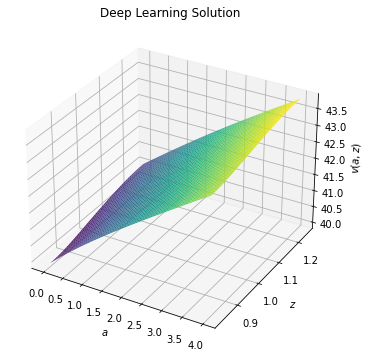

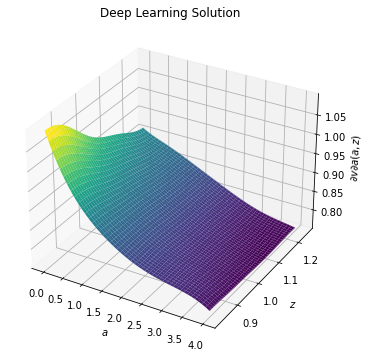

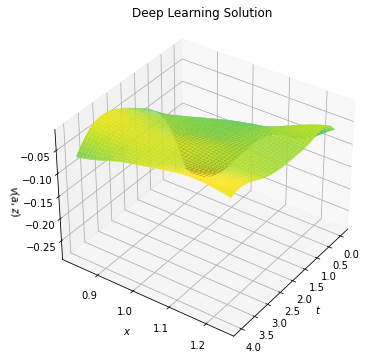

In [13]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T


with tf.GradientTape(persistent=True) as tape:
    # Split t and x to compute partial derivatives
    a, z = tf.cast(Xgrid, DTYPE)[:, 0:1], tf.cast(Xgrid, DTYPE)[:, 1:2]
    # Variables t and x are watched during tape
    # to compute derivatives u_t and u_x
    tape.watch(a)
    tape.watch(z)

#     # Determine residual
    v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

#     # Compute gradient u_x within the GradientTape
#     # since we need second derivatives
    v_a = tape.gradient(v, a)

v_aa = tape.gradient(v_a, a)
del tape
# # Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid, DTYPE))
U = upred.numpy().reshape(N+1, N+1)
v_aplot = v_a.numpy().reshape(N+1, N+1)
v_aaplot = v_aa.numpy().reshape(N+1, N+1)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
# ax.view_init(35, 35)
ax.set_xlabel('$a$')
ax.set_ylabel('$z$')
ax.set_zlabel('$v(a,z)$')
ax.set_title('Deep Learning Solution')
plt.savefig('HJB_V.pdf', bbox_inches='tight', dpi=300)
# plt.close()

# # Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, v_aplot, cmap='viridis')
# ax.view_init(35, 35)
ax.set_xlabel('$a$')
ax.set_ylabel('$z$')
ax.set_zlabel('$\partial v \partial a (a,z)$')
ax.set_title('Deep Learning Solution')
plt.savefig('HJB_Va.pdf', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, v_aaplot, cmap='viridis')
ax.view_init(35, 35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$v(a,z)$')
ax.set_title('Deep Learning Solution')


In [67]:
v_aaplot.min(), v_aaplot.max(), v_aplot.min(), v_aplot.max()


(-0.55985254, -0.013229236, 0.75317144, 1.0986345)